Building an Image Classifier using CNN

#Setup

In [148]:
import tensorflow as tf
from tensorflow import keras
import sklearn
import numpy as np
np.random.seed(42)
import matplotlib as mpl
import matplotlib.pyplot as plt

import kagglehub
import os
import pandas as pd
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [95]:
path = kagglehub.dataset_download("alessiocorrado99/animals10")

train_ds_128 = image_dataset_from_directory(f"{path}/raw-img", validation_split=0.2,subset="training",seed=67,image_size=(128, 128),batch_size=32)
test_ds_128 = image_dataset_from_directory(f"{path}/raw-img",validation_split=0.2,subset="validation",seed=67,image_size=(128, 128),batch_size=32)

train_ds_224 = image_dataset_from_directory(f"{path}/raw-img", validation_split=0.2,subset="training",seed=67,image_size=(224, 224),batch_size=32)
test_ds_224 = image_dataset_from_directory(f"{path}/raw-img",validation_split=0.2,subset="validation",seed=67,image_size=(224, 224),batch_size=32)

Using Colab cache for faster access to the 'animals10' dataset.
Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.
Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


# Build a neural network model

Model from Scratch

In [104]:
scratch = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),

    tf.keras.layers.Conv2D(32, 3, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, 3, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128, 3, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(256, 3, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation="softmax")
])

Model w/ Transfer Learning

In [105]:
base_model = tf.keras.applications.EfficientNetB1(input_shape=(224, 224, 3),include_top=False,weights="imagenet")
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

transfer = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.Lambda(tf.keras.applications.efficientnet.preprocess_input),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation="relu",kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation="softmax")
])



In [106]:
scratch.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_23 (Rescaling)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_4 (RandomZoom)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_4               │ (None, 128, 128, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_14 (RandomFlip)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_14              │ (None, 128, 128, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_40 (ReLU)                 │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_41 (ReLU)                 │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_42 (ReLU)                 │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_43 (ReLU)                 │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_16     │ (None, 256)            │             

 Total params: 424,522 (1.62 MB)

 Trainable params: 423,562 (1.62 MB)

 Non-trainable params: 960 (3.75 KB)

In [107]:
transfer.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_15 (RandomFlip)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_15              │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_4 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb1 (Functional)     │ (None, 7, 7, 1280)     │     6,575,239 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_17     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,740,497 (25.71 MB)

 Trainable params: 2,637,066 (10.06 MB)

 Non-trainable params: 4,103,431 (15.65 MB)

#compiling the model:


In [108]:
scratch.compile(loss="sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(3e-4),
              metrics=["accuracy"])

In [109]:
transfer.compile(loss="sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=["accuracy"])

# training neural network model:


In [110]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=15,
    restore_best_weights=True
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [111]:
history_s = scratch.fit(train_ds_128, batch_size = 32, epochs=100, validation_data=test_ds_128, callbacks=[early_stop])

Epoch 1/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.2769 - loss: 2.0983 - val_accuracy: 0.3127 - val_loss: 1.9690
Epoch 2/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.4195 - loss: 1.6768 - val_accuracy: 0.2669 - val_loss: 2.5630
Epoch 3/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.4735 - loss: 1.5202 - val_accuracy: 0.3845 - val_loss: 1.8463
Epoch 4/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.5094 - loss: 1.4234 - val_accuracy: 0.3240 - val_loss: 2.1719
Epoch 5/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.5451 - loss: 1.3386 - val_accuracy: 0.5033 - val_loss: 1.4414
Epoch 6/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.5618 - loss: 1.2744 - val_accuracy: 0.4266 - val_loss: 1.7892
Epoch 7/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.5803 - loss: 1.2226 - val_accuracy: 0.4390 - val_loss: 1.6297
Epoch 8/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.5983 - loss: 1

In [112]:
history_t = transfer.fit(train_ds_224, batch_size = 32, epochs=5, validation_data=test_ds_224)

Epoch 1/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 50s 48ms/step - accuracy: 0.3304 - loss: 2.0017 - val_accuracy: 0.9138 - val_loss: 0.7223
Epoch 2/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 28s 42ms/step - accuracy: 0.8692 - loss: 0.6741 - val_accuracy: 0.9608 - val_loss: 0.2836
Epoch 3/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 28s 42ms/step - accuracy: 0.9274 - loss: 0.3526 - val_accuracy: 0.9687 - val_loss: 0.1786
Epoch 4/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 28s 42ms/step - accuracy: 0.9405 - loss: 0.2601 - val_accuracy: 0.9733 - val_loss: 0.1413
Epoch 5/5
655/655 ━━━━━━━━━━━━━━━━━━━━ 28s 42ms/step - accuracy: 0.9486 - loss: 0.2213 - val_accuracy: 0.9738 - val_loss: 0.1240


#Evaluation



In [113]:
score_s = scratch.evaluate(test_ds_128)

164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7367 - loss: 0.8036


In [114]:
score_t = transfer.evaluate(test_ds_224)

164/164 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9744 - loss: 0.1209


In [115]:
print('Total loss on Testing Set w/ Scratch Model:', score_s[0])
print('Accuracy of Testing Set: w/ Scratch Model', score_s[1])

Total loss on Testing Set w/ Scratch Model: 0.8031288981437683
Accuracy of Testing Set: w/ Scratch Model 0.7371537685394287


In [116]:
print('Total loss on Testing Set w/ Transfer Model:', score_t[0])
print('Accuracy of Testing Set: w/ Transfer Model', score_t[1])

Total loss on Testing Set w/ Transfer Model: 0.12403377890586853
Accuracy of Testing Set: w/ Transfer Model 0.973829984664917


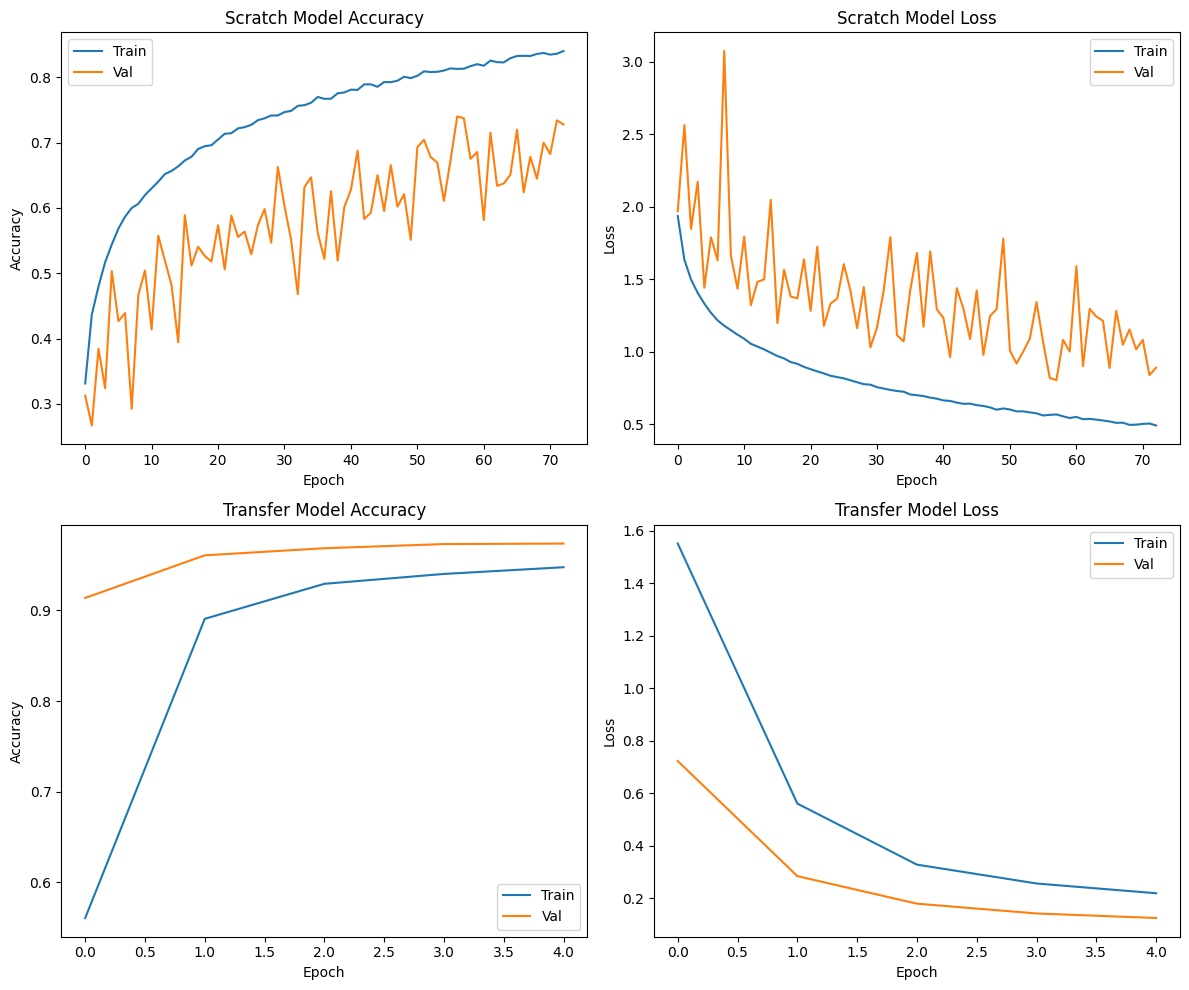

In [144]:
plt.figure(figsize=(12, 10))

# scratch
plt.subplot(2, 2, 1)
plt.plot(history_s.history['accuracy'], label='Train')
plt.plot(history_s.history['val_accuracy'], label='Val')
plt.title('Scratch Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history_s.history['loss'], label='Train')
plt.plot(history_s.history['val_loss'], label='Val')
plt.title('Scratch Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# transfer
plt.subplot(2, 2, 3)
plt.plot(history_t.history['accuracy'], label='Train')
plt.plot(history_t.history['val_accuracy'], label='Val')
plt.title('Transfer Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(history_t.history['loss'], label='Train')
plt.plot(history_t.history['val_loss'], label='Val')
plt.title('Transfer Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

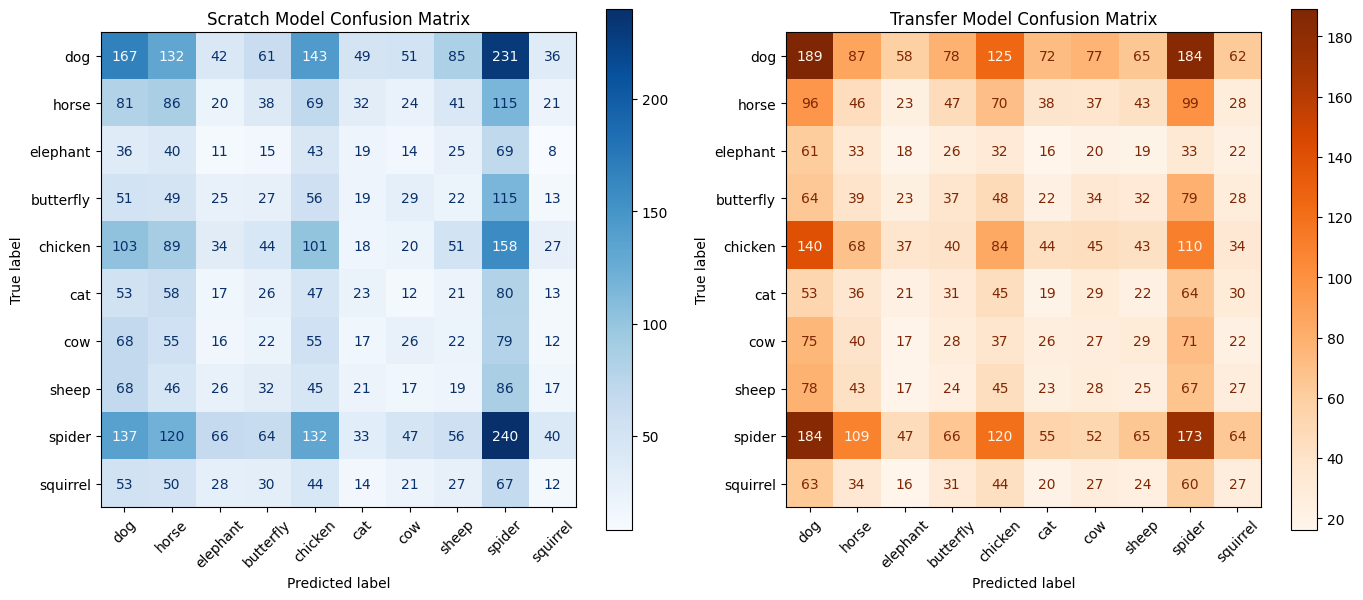

In [185]:
def get_preds_labels(model, dataset):
    y_true = np.concatenate([np.argmax(y, axis=1) if y.ndim > 1 else y for x, y in dataset], axis=0)
    y_pred = np.concatenate([np.argmax(model.predict(x, verbose=0), axis=1) for x, y in dataset], axis=0)
    return y_true, y_pred

translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "dog": "cane", "cavallo": "horse", "elephant" : "elefante", "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto", "cow": "mucca", "ragno": "spider", "squirrel": "scoiattolo"}
class_names_s = [translate.get(name, name) for name in train_ds_128.class_names]
class_names_t = [translate.get(name, name) for name in train_ds_224.class_names]

y_true_s, y_pred_s = get_preds_labels(scratch, test_ds_128)
y_true_t, y_pred_t = get_preds_labels(transfer, test_ds_224)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

cm_s = confusion_matrix(y_true_s, y_pred_s)
disp_s = ConfusionMatrixDisplay(cm_s, display_labels=class_names_s)
disp_s.plot(ax=axes[0], cmap=plt.cm.Blues, xticks_rotation=45)
axes[0].set_title("Scratch Model Confusion Matrix")

cm_t = confusion_matrix(y_true_t, y_pred_t)
disp_t = ConfusionMatrixDisplay(cm_t, display_labels=class_names_t)
disp_t.plot(ax=axes[1], cmap=plt.cm.Oranges, xticks_rotation=45)
axes[1].set_title("Transfer Model Confusion Matrix")

plt.tight_layout()
plt.show()


#Predicting the first three images from the test set


1.   print the predicted results of the first three images from the test set
2.   print the real label of the first three images from the test set



In [170]:
for images, labels in test_ds_128.take(1):
    X_new_s = images[:3]
    y_true_s = labels[:3]
y_proba_s = scratch.predict(X_new_s)
y_proba_s.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.52, 0.  , 0.  , 0.  , 0.  , 0.47],
       [0.64, 0.34, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [171]:
for images, labels in test_ds_224.take(1):
    X_new_t = images[:3]
    y_true_t = labels[:3]
y_proba_t = transfer.predict(X_new_t)
y_proba_t.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


array([[0.  , 0.  , 0.04, 0.  , 0.  , 0.  , 0.  , 0.95, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.99, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [172]:
y_proba_s = scratch.predict(X_new_s)
y_pred_s = np.argmax(y_proba_s, axis=-1)
y_pred_s

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


array([4, 0, 3])

In [173]:
y_proba_t = transfer.predict(X_new_t)
y_pred_t = np.argmax(y_proba_t, axis=-1)
y_pred_t

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


array([7, 8, 5])

In [179]:
it_class_names = train_ds_224.class_names
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "dog": "cane", "cavallo": "horse", "elephant" : "elefante", "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto", "cow": "mucca", "ragno": "spider", "squirrel": "scoiattolo"}
class_names = [translate.get(name, name) for name in it_class_names]
class_names

['dog',
 'horse',
 'elephant',
 'butterfly',
 'chicken',
 'cat',
 'cow',
 'sheep',
 'spider',
 'squirrel']

In [180]:
print(np.array(class_names)[y_pred_s])
print(np.array(class_names)[y_pred_t])

['chicken' 'dog' 'butterfly']
['sheep' 'spider' 'cat']


In [181]:
print(y_true_s)
print(y_true_t)

tf.Tensor([9 0 3], shape=(3,), dtype=int32)
tf.Tensor([7 8 5], shape=(3,), dtype=int32)


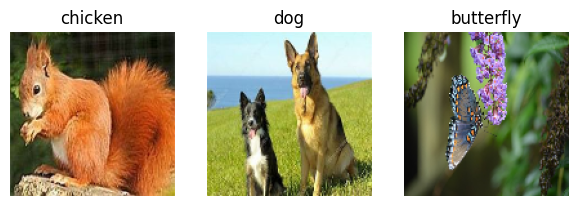

In [182]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new_s):
    plt.subplot(1, 3, index + 1)

    img = image / 255.0

    plt.imshow(img)
    plt.axis('off')
    plt.title(class_names[y_pred_s[index]], fontsize=12)

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

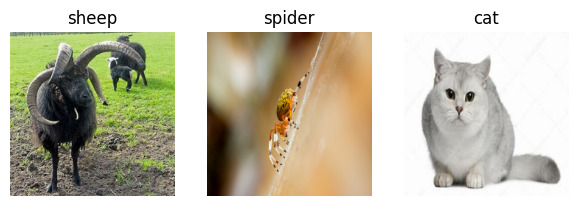

In [183]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new_t):
    plt.subplot(1, 3, index + 1)

    img = image / 255.0

    plt.imshow(img)
    plt.axis('off')
    plt.title(class_names[y_pred_t[index]], fontsize=12)

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()